In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import LabelEncoder
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from colorama import Style, Fore
blk = Style.BRIGHT + Fore.BLACK
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
res = Style.RESET_ALL

import os
train = pd.read_csv('/kaggle/input/playground-series-s3e19/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e19/test.csv')
test['num_sold'] = float('nan') # this is dummy for simplify concat

train.columns

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Index(['id', 'date', 'country', 'store', 'product', 'num_sold'], dtype='object')

In [2]:
analysis = train
uniques = {}

for column in analysis.columns:
    uniques[column] = analysis[column].unique().tolist()
    if column not in ['date', 'num_sold','id']:
        print(uniques[column])

['Argentina', 'Canada', 'Estonia', 'Japan', 'Spain']
['Kaggle Learn', 'Kaggle Store', 'Kagglazon']
['Using LLMs to Improve Your Coding', 'Using LLMs to Train More LLMs', 'Using LLMs to Win Friends and Influence People', 'Using LLMs to Win More Kaggle Competitions', 'Using LLMs to Write Better']


In [3]:
# To Datetime
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

df = pd.concat([train, test], axis=0)


In [4]:
le = LabelEncoder()
cols = ['country', 'store', 'product']
for col in cols:
    df[col] = le.fit_transform(df[col])

In [5]:
import datetime as dt

# date column is separated for each element
df['day']   = df['date'].dt.day
df['week' ] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month
df['year']  = df['date'].dt.year

In [6]:
df.head()

,id,date,country,store,product,num_sold,day,week,month,year
0,0,2017-01-01,0,1,0,63.0,1,6,1,2017
1,1,2017-01-01,0,1,1,66.0,1,6,1,2017
2,2,2017-01-01,0,1,2,9.0,1,6,1,2017
3,3,2017-01-01,0,1,3,59.0,1,6,1,2017
4,4,2017-01-01,0,1,4,49.0,1,6,1,2017


In [7]:
def seasonality_features(df_temp):
    df_copy = df_temp.copy()  # Criar uma cópia do DataFrame
    df_copy['month_sin'] = np.sin(2*np.pi*df_copy.month/12)
    df_copy['month_cos'] = np.cos(2*np.pi*df_copy.month/12)
    df_copy['day_sin'] = np.sin(2*np.pi*df_copy.day/24)
    df_copy['day_cos'] = np.cos(2*np.pi*df_copy.day/24)
    return df_copy

df_modified = seasonality_features(df)

df_modified = df_modified.drop('date', axis=1)
df_modified.head()

,id,country,store,product,num_sold,day,week,month,year,month_sin,month_cos,day_sin,day_cos
0,0,0,1,0,63.0,1,6,1,2017,0.5,0.866025,0.258819,0.965926
1,1,0,1,1,66.0,1,6,1,2017,0.5,0.866025,0.258819,0.965926
2,2,0,1,2,9.0,1,6,1,2017,0.5,0.866025,0.258819,0.965926
3,3,0,1,3,59.0,1,6,1,2017,0.5,0.866025,0.258819,0.965926
4,4,0,1,4,49.0,1,6,1,2017,0.5,0.866025,0.258819,0.965926


In [8]:
def set_frame_style(df, caption=""):
    """Helper function to set dataframe presentation style.
    """
    return df.style.background_gradient(cmap='Blues').set_caption(caption).set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'Blue'),
        ('font-size', '18px'),
        ('font-weight','bold')
    ]}])


display(set_frame_style(df_modified.describe(),' Data : Summary Statistics'))

,id,country,store,product,num_sold,day,week,month,year,month_sin,month_cos,day_sin,day_cos
count,164325.000000,164325.000000,164325.000000,164325.000000,136950.000000,164325.000000,164325.000000,164325.000000,164325.000000,164325.000000,164325.000000,164325.000000,164325.000000
mean,82162.000000,2.000000,1.000000,2.000000,165.522636,15.726609,3.000000,6.523962,2019.500228,-0.004983,-0.002143,0.154809,0.102822
std,47436.685830,1.414218,0.816499,1.414218,183.691575,8.798839,2.000006,3.448430,1.707474,0.705718,0.708476,0.705982,0.683415
min,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,0.000000,1.000000,2017.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,41081.000000,1.000000,0.000000,1.000000,46.000000,8.000000,1.000000,4.000000,2018.000000,-0.866025,-0.866025,-0.500000,-0.500000
50%,82162.000000,2.000000,1.000000,2.000000,98.000000,16.000000,3.000000,7.000000,2020.000000,-0.000000,-0.000000,0.258819,0.258819
75%,123243.000000,3.000000,2.000000,3.000000,184.000000,23.000000,5.000000,10.000000,2021.000000,0.500000,0.866025,0.866025,0.707107
max,164324.000000,4.000000,2.000000,4.000000,1380.000000,31.000000,6.000000,12.000000,2022.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
# Separar o conjunto de treinamento e o conjunto de teste após o encoding
df_train = df_modified.loc[~df_modified['num_sold'].isna()]
df_test = df_modified.loc[df_modified['num_sold'].isna()]

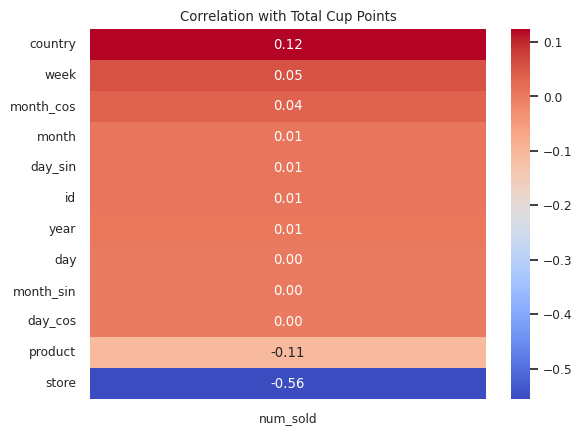

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score


corr = df_train.corr(numeric_only=True)
target_corr = corr['num_sold'].drop('num_sold')

# Sort correlation values in descending order
target_corr_sorted = target_corr.sort_values(ascending=False)

# Create a heatmap of the correlations with the target column
sns.set(font_scale=0.8)
sns.set_style("white")
sns.set_palette("PuBuGn_d")
sns.heatmap(target_corr_sorted.to_frame(), cmap="coolwarm", annot=True, fmt='.2f')
plt.title('Correlation with Total Cup Points')
plt.show()

In [11]:
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit



def objective(trial, df):
    X = df.drop(['num_sold', 'id'], axis=1)
    y = df['num_sold']
    
    # Definir o número de splits desejados
    n_splits = 5

    # Criar o objeto TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Variável para armazenar a soma das métricas de cada fold
    total_smape = 0

    # Loop pelos splits do TimeSeriesSplit
    for train_index, val_index in tscv.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Definir os hiperparâmetros a serem otimizados
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'max_depth': trial.suggest_int('max_depth', 3, 15),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
            'random_state': 0
        }

        # Criar o modelo RandomForestRegressor com os hiperparâmetros definidos
        model = RandomForestRegressor(**params)

        # Treinar o modelo
        model.fit(X_train, y_train)

        # Prever os valores do conjunto de validação
        y_pred = model.predict(X_val)

        # Calcular a métrica de avaliação (SMAPE)
        smape = calculate_smape(y_val, y_pred)

        total_smape += smape

    # Calcular a média das métricas dos folds
    avg_smape = total_smape / n_splits

    return avg_smape



def calculate_smape(y_true, y_pred):
    return 1 / len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)) * 100)



In [12]:
def train_rf_regressor(df):
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, df), n_trials=3)

    # Obter os melhores parâmetros encontrados
    best_params = study.best_params
    
    X = df.drop('num_sold', axis=1)
    y = df['num_sold']

    # Criar o objeto TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=5)

    # Lista para armazenar os modelos treinados
    models = []

    # Loop pelos splits do TimeSeriesSplit
    for train_index, val_index in tscv.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Treinar um novo modelo usando os melhores parâmetros
        model = RandomForestRegressor(**best_params)
        model.fit(X_train, y_train)

        models.append(model)

    return models


In [13]:
best_model = train_rf_regressor(df_train)

[I 2023-07-13 21:54:05,181] A new study created in memory with name: no-name-2551e26b-b739-4f5c-b91c-67af7ad7e7a3
[I 2023-07-13 22:00:40,596] Trial 0 finished with value: 12.30799194985527 and parameters: {'n_estimators': 612, 'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 5}. Best is trial 0 with value: 12.30799194985527.
[I 2023-07-13 22:08:26,931] Trial 1 finished with value: 12.229263269396576 and parameters: {'n_estimators': 615, 'max_depth': 13, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 1 with value: 12.229263269396576.
[I 2023-07-13 22:20:42,392] Trial 2 finished with value: 12.217417594532966 and parameters: {'n_estimators': 865, 'max_depth': 14, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 2 with value: 12.217417594532966.


In [14]:
df_test = df_test.drop(['num_sold'], axis=1)

In [15]:
divisor = 4  # Escolha o divisor desejado

sample_submission = pd.read_csv('/kaggle/input/playground-series-s3e19/sample_submission.csv')

# Loop pelos modelos treinados
for model in best_model:
    # Fazer previsões para o modelo atual
    predictions = model.predict(df_test)

    # Dividir as previsões pelo divisor escolhido
    predictions /= divisor

    # Adicionar as previsões do modelo atual ao DataFrame de submissão
    sample_submission['num_sold'] += predictions

# Salvar o DataFrame em um arquivo CSV
sample_submission.to_csv('submission.csv', index=False)
